### Pipeline Stage 4: Filtering Based on Keyword Scores

Welcome to Pipeline 4! In this stage, we will use the scores generated from Pipeline 3 to identify and select the best matches between students and companies. This filtering process ensures that the highest-scoring pairs, indicating the strongest alignment, are prioritized, leading to optimal matches for both students and employers.

In [1]:
#~~~
import os 
import re
import time 
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from fuzzywuzzy import fuzz
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

# Custom imports
from mypackage.utils import *

In [ ]:
# Load the project path
path_to_project = load_project_path()

if path_to_project:
    print(f"Project path loaded: {path_to_project}")
else:
    print("Please set the project path in the initial notebook.")

In [3]:
SP_load_path = f'{path_to_project}/data/SP_table/SP3_post_keyword_scoring.parquet'
SP = pd.read_parquet(SP_load_path)
print(SP.shape) 

(27697, 68)


Below is code to calculate the Pearson correlation coefficient between the Total Points and Extraction_total_points columns. I wanted to see if the new scoring logic I implemented has a strong correlation with the original scoring logic.

Pearson correlation coefficient: 0.37775821419065103
P-value: 0.0


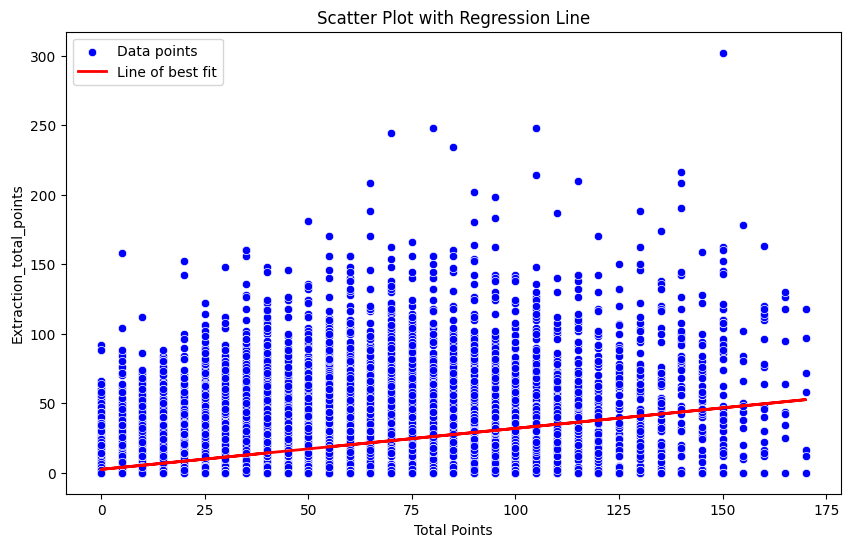

Regression slope: 0.29492452449359957
Regression intercept: 2.401915354691763


In [4]:
# Calculate the Pearson correlation coefficient
def calculate_correlation(df):
    correlation, p_value = pearsonr(df['Total Points'], df['Extraction_total_points'])
    print(f"Pearson correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")
    return correlation

# Plot the scatter plot and regression line
def plot_regression(df):
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Total Points', y='Extraction_total_points', data=df, color='blue', label='Data points')

    # Perform linear regression
    X = df['Total Points'].values.reshape(-1, 1)
    y = df['Extraction_total_points'].values
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Plot regression line
    plt.plot(df['Total Points'], y_pred, color='red', linewidth=2, label='Line of best fit')
    
    # Add labels and title
    plt.xlabel('Total Points')
    plt.ylabel('Extraction_total_points')
    plt.title('Scatter Plot with Regression Line')
    plt.legend()
    plt.show()

    print(f"Regression slope: {reg.coef_[0]}")
    print(f"Regression intercept: {reg.intercept_}")

# Perform the analysis on the DataFrame
def perform_correlation_analysis(df):
    # Step 1: Calculate correlation
    calculate_correlation(df)
    
    # Step 2: Plot and perform regression
    plot_regression(df)

# Assuming your DataFrame is called SP, you would run:
perform_correlation_analysis(SP)


The plot shows a significant but only moderate correlation between the Total Points and Extraction_total_points columns. So a higher match score score based on the current logic does not necessarily mean a higher match score based on the new logic.

In [5]:
''' 
We will now apply some filtering based on the generated scores. 
The goal with filtering is to make sure only qualified candidates are matched with job postings. 
'''

' \nWe will now apply some filtering based on the generated scores. \nThe goal with filtering is to make sure only qualified candidates are matched with job postings. \n'

In [6]:
# Filter out rows where Extraction_total_points is 0
SP = SP[SP['Extraction_total_points'] > 0]

# Be sure to Identify the Job Postings that were entirely deleted
# Group by 'pos_(Do Not Modify) Job Posting' and find those that have no remaining rows in SP_filtered
deleted_postings = SP[~SP['pos_(Do Not Modify) Job Posting'].isin(SP['pos_(Do Not Modify) Job Posting'])]

print("Number of deleted job postings:")
print(len(deleted_postings))

Number of deleted job postings:
0


### Summary of the Matching Strategy

This code implements an iterative matching strategy designed to ensure that each student is matched with no more than 5 companies, while prioritizing the highest alignment scores (`Extraction_total_points`) between students and companies.

#### Key Steps in the Matching Process:

1. **Initial Sorting:**
   - The DataFrame `SP` is sorted by `pos_(Do Not Modify) Job Posting` and `Extraction_total_points` in descending order. This ensures that for each company, the top matches (with the highest alignment scores) are prioritized.

2. **Iterative Matching Rounds:**
   - The matching process is conducted in multiple rounds. In each round, the top match for each company is selected from the remaining pool of students.

3. **Processing Top Matches:**
   - For each company in a given round, the top match (the student with the highest alignment score for that company) is identified and collected.

4. **Tracking Student Matches:**
   - The code maintains a dictionary (`student_matches`) that tracks all the matches for each student across all rounds.
   - After collecting new matches for the current round, the code ensures that each student retains only their top 5 matches based on `Extraction_total_points`.

5. **Updating Final Matches:**
   - The selected matches (limited to the top 5 for each student) are added to the `final_matches` DataFrame, which accumulates all the valid matches throughout the process.

6. **Removing Fully Matched Students:**
   - Students who have reached their maximum of 5 matches are removed from the pool (`SP_sorted`). This ensures they are not considered in subsequent rounds, preventing over-matching.

7. **Loop Termination:**
   - The loop continues until no students are left in the pool (`SP_sorted.empty`), meaning all students have either reached their maximum matches or no suitable matches remain.

8. **Counting Rounds:**
   - The variable `num_rounds` tracks the number of iterations (rounds) needed to complete the matching process.

#### Output:
- The final output is a DataFrame `final_matches` that contains all the matches, limited to the top 5 matches per student, ensuring an optimal distribution based on alignment scores.
- Additionally, the number of rounds taken to complete the matching process is printed, providing insight into the efficiency of the matching strategy.

### Key Characteristics of the Strategy:
- **Prioritization of Top Matches:** The strategy consistently prioritizes the highest alignment scores for each company, ensuring that the best possible matches are made.
- **Controlled Match Distribution:** By limiting each student to a maximum of 5 matches, the strategy prevents any student from being over-matched, ensuring a fair distribution across all companies.
- **Iterative Approach:** The iterative nature of the strategy allows for flexibility, as it continuously re-evaluates and refines the matches until an optimal solution is reached.

This approach is efficient and ensures that the most aligned matches are prioritized while adhering to the constraint that no student is matched with more than 5 companies.

In [7]:
num_rounds = 0
# Step 1: Sort the DataFrame by company and alignment score
SP_sorted = SP.sort_values(by=['pos_(Do Not Modify) Job Posting', 'Extraction_total_points'], ascending=[True, False])

# Initialize an empty DataFrame to store the final matches
final_matches = pd.DataFrame(columns=SP.columns)

# Initialize a dictionary to keep track of all student matches (not just counts)
student_matches = defaultdict(list)

# Set the maximum number of matches each company and student should get
max_matches_per_student = 5

# Iterative matching process
while not SP_sorted.empty:
    # Get the top match for each company
    top_matches = SP_sorted.groupby('pos_(Do Not Modify) Job Posting').head(1)

    # Initialize a list to collect matches for this round
    round_matches = []

    # Process each top match
    for index, row in top_matches.iterrows():
        student = row['stu_(Do Not Modify) Application']
        company = row['pos_(Do Not Modify) Job Posting']

        # Collect matches for each student
        round_matches.append(row)
    
    # Convert round_matches to DataFrame
    round_matches_df = pd.DataFrame(round_matches)

    # Update the student_matches dictionary with new matches
    for student in round_matches_df['stu_(Do Not Modify) Application'].unique():
        # Append new matches for this student
        student_matches[student].extend(round_matches_df[round_matches_df['stu_(Do Not Modify) Application'] == student].to_dict('records'))
        
        # Keep only the top 5 matches for the student
        student_matches[student] = sorted(student_matches[student], key=lambda x: x['Extraction_total_points'], reverse=True)[:max_matches_per_student]

    # Create a DataFrame from the selected matches to add to final_matches
    selected_matches = pd.DataFrame([match for matches in student_matches.values() for match in matches])
    
    if num_rounds == 0:
        final_matches = selected_matches.copy()
    else:
        final_matches = pd.concat([final_matches, selected_matches]).drop_duplicates().reset_index(drop=True)

    # Remove students who have reached their maximum matches from SP_sorted
    fully_matched_students = [student for student, matches in student_matches.items() if len(matches) >= max_matches_per_student]
    SP_sorted = SP_sorted[~SP_sorted['stu_(Do Not Modify) Application'].isin(fully_matched_students)]
    
    num_rounds += 1
    # Stop if there are no more students to match

# final_matches now contains the distributed matches limited to the top 5 for each student
print(f"Number of rounds: {num_rounds}")
print(f"Number of final matches: {final_matches.shape[0]}")


Number of rounds: 44
Number of final matches: 884


In [9]:
''' 
We now have a dataframe containing the filtered matches. I will print the number of matches each company and student received.
'''

pos_cols = ''' 
pos_Name
pos_Company
pos_(Do Not Modify) Job Posting
'''
pos_cols = as_list(pos_cols)

company_match_counts = final_matches[pos_cols].copy()

# add a column to company_match_counts that counts the number of matches each company received. This is done by counting the number of times 'pos_(Do Not Modify) Job Posting' shows up in the final_matches dataframe.
company_match_counts['num_matches'] = company_match_counts.groupby('pos_(Do Not Modify) Job Posting')['pos_(Do Not Modify) Job Posting'].transform('count')

# drop duplicates
company_match_counts = company_match_counts.drop_duplicates().reset_index(drop=True)

# sort by num_matches
company_match_counts = company_match_counts.sort_values(by='num_matches', ascending=False)

stu_cols = ''' 
stu_Legal Name
stu_(Do Not Modify) Application
'''

stu_cols = as_list(stu_cols)

student_match_counts = final_matches[stu_cols].copy()

# add a column to student_match_counts that counts the number of matches each student received. This is done by counting the number of times 'stu_(Do Not Modify) Application' shows up in the final_matches dataframe.
student_match_counts['num_matches'] = student_match_counts.groupby('stu_(Do Not Modify) Application')['stu_(Do Not Modify) Application'].transform('count')

# drop duplicates
student_match_counts = student_match_counts.drop_duplicates().reset_index(drop=True)

# sort by num_matches
student_match_counts = student_match_counts.sort_values(by='num_matches', ascending=False)

In [10]:
pretty_print(company_match_counts[['pos_Company', 'pos_Name', 'num_matches']])

+-------+----------------------------------+--------------------------------------------------------------------------+-------------+
| Index |           pos_Company            |                                 pos_Name                                 | num_matches |
+-------+----------------------------------+--------------------------------------------------------------------------+-------------+
|   17  |         Creative Agency          |                             Artistry Intern                              |      16     |
|   3   |           Design Firm            |                           Marketing Internship                           |      15     |
|   18  |         Healthcare Group         |                           Marketing Assistant                            |      15     |
|   34  |      Health Services Group       |                           Marketing Assistant                            |      13     |
|   93  |       EcoConsulting Group        |                  

In [11]:
pretty_print(student_match_counts[['stu_Legal Name', 'num_matches']])

+-------+---------------------+-------------+
| Index |    stu_Legal Name   | num_matches |
+-------+---------------------+-------------+
|  339  |       Alex Lee      |      7      |
|  367  |      Alex Smith     |      6      |
|  374  |     Jordan Smith    |      6      |
|  365  |       John Doe      |      5      |
|  298  |     Alex Parker     |      5      |
|  354  |     Alex Linden     |      5      |
|   23  |      Jordan Lee     |      5      |
|  355  |       John Doe      |      5      |
|  206  |    Pseudonym Doe    |      5      |
|  342  |      Jamie Lee      |      5      |
|  303  |    Jordan Nguyen    |      5      |
|  362  |     Alex Taylor     |      5      |
|   1   |     Alex Johnson    |      5      |
|  371  |      Alex Chen      |      5      |
|  372  |     Alex Johnson    |      5      |
|  375  |       Alex Kim      |      5      |
|   43  |    Alex Martinez    |      5      |
|   5   |     Alex Harper     |      5      |
|  377  |     Alex Johnson    |   

### Final Results

The final results from the matching process yield a more evenly distributed set of matches. Every student is matched with at least one job posting, and each company receives at least four matches. In the next step of the pipeline, we will narrow down these matches to identify the top three candidates for each job posting. Below are some examples of the matches that were generated by this process.

In [17]:
# Below is a list of Companies from 2024. If you'd like to see the matches for a specific company, copy and paste the name in the 'Company_Name' variable below.

company_names = company_match_counts['pos_Company'].unique()
for company in company_names:
    print(company)

Creative Agency
Design Firm
Healthcare Group
Health Services Group
EcoConsulting Group
Tech Firm
Design Agency
Advertising Solutions Firm
Health Solutions Organization
Community Nonprofit
Environmental Consulting Group
Health Network Inc.
Clothing Brand
Media Group
Media Enterprise
Footwear Innovators
Healthcare Solutions Inc.
Tech Group
Umbrella Tactics
Union Credit
Consulting Firm
Footwear Corporation
Community Support Organization
Community Financial Cooperative
Tech Solutions
Finance Associates
Athletic Gear Company
Energy Firm
Visionary Solutions
Financial Solutions Group
Tech Collective
United Cider Organization
Compass
CityDesigners Co.
Creative Solutions Inc.
EcoSolutions Group
Finance Cooperative
Green Initiatives Organization
Creative Solutions Agency
Nonprofit Organization
Family Support Network
GlobalConnect
Creative Solutions Co.
Local Financial Institution
Tech Supplies Co.
Apparel Brand
Community Trust Foundation
Tech Innovators
Innovative Ventures
Ice Cream Firm
GreenTe

In [18]:
Company_Name = 'Clothing Brand'

cols = ''' 
pos_Company
pos_Name
stu_Legal Name
Extraction_total_points
Tech_total_points_breakup
Industry_total_points_breakup
Values_total_points_breakup
Soft_Skills_total_points_breakup
Total Points
Total Points BreakUp
Tech_total_points
pos_technical_keywords
stu_technical_keywords
Industry_total_points
pos_industry_keywords
stu_industry_keywords
Soft_Skills_total_points
pos_soft_keywords
stu_soft_keywords
Values_total_points
pos_values_keywords
stu_values_keywords
pos_(Do Not Modify) Job Posting
stu_(Do Not Modify) Application
'''

# create a subset of SP with the columns in cols
company_match = final_matches[as_list(cols)]
company_match = (company_match[company_match['pos_Company'] == Company_Name])

# print legacy_health, order by 'Extraction_total_points' in descending order
pretty_print(company_match.sort_values(by='Extraction_total_points', ascending=False))

+-------+----------------+-------------------------+----------------+-------------------------+------------------------------------------------------------+-------------------------------+-----------------------------+----------------------------------+--------------+---------------------------------------------------------------+-------------------+----------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+-----------------------+--------------------------------------------+---------------------------------------------------------------+--------------------------+--------------------------------------------------------------+------------------------------------------------------------------------+---------------------+------------------------------------------------------------------------------------+-----------------------------------------------------------+--